# Bank Marketing in R using h2o AutoML

More info on H2O AutoML at https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html

Install and load required packages

In [1]:
if(!require('h2o')){install.packages('h2o')}
if(!require('h2o4gpu')){install.packages('h2o4gpu')}
if(!require('getPass')){install.packages('getPass')}

Loading required package: h2o


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc


Loading required package: h2o4gpu


Attaching package: ‘h2o4gpu’


The following object is masked from ‘package:base’:

    transform


Loading required package: getPass



In [2]:
library('tidyverse')
library('caret')
library("DBI")
library('dplyr')
library('dbplyr')
library('tdplyr')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘dbplyr’


The following objects are masked from ‘package:dplyr’:

    ident, sql


Registered S3 methods overwritten by 'tdplyr':
  method                     from  
  db_analyze.Teradata        dbplyr
  sql_select.Teradata        dbplyr
  sql_translate_env.Teradata dbplyr



Replace your cluster details for your user, password, host and database.

In [3]:
host <- "3.238.151.85"
user <- "AOA_DEMO"
database <- "AOA_DEMO"
password <- getPass::getPass("Enter the password: ")
params <- sprintf("{\"host\":\"%s\",\"user\":\"%s\",\"password\":\"%s\",\"database\":\"%s\"}", host, user, password, database)
con <- DBI::dbConnect(teradatasql::TeradataDriver(), paste0(params)) 

Enter the password:  ··········


## Exploratory analysis

Load the dataset

In [4]:
bank <- DBI::dbGetQuery(con, "select * from BANK_MARKETING_DATA")
bank$job <- as.factor(bank$job)
bank$marital <- as.factor(bank$marital)
bank$education <- as.factor(bank$education)
bank$default <- as.factor(bank$default)
bank$balance <- as.integer(bank$balance)
bank$housing <- as.factor(bank$housing)
bank$loan <- as.factor(bank$loan)
bank$contact <- as.factor(bank$contact)
bank$day <- as.integer(bank$day)
bank$month <- as.factor(bank$month)
bank$pdays <- as.integer(bank$pdays)
bank$poutcome <- as.factor(bank$poutcome)
bank$y <- as.factor(bank$y)

Let's inspect the dataset

In [5]:
str(bank)

'data.frame':	4521 obs. of  17 variables:
 $ age      : int  30 33 35 30 59 35 36 39 41 43 ...
 $ job      : Factor w/ 12 levels "admin.","blue-collar",..: 11 8 5 5 2 5 7 10 3 8 ...
 $ marital  : Factor w/ 3 levels "divorced","married",..: 2 2 3 2 2 3 2 2 2 2 ...
 $ education: Factor w/ 4 levels "primary","secondary",..: 1 2 3 3 2 3 3 2 3 1 ...
 $ default  : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ balance  : int  1787 4789 1350 1476 0 747 307 147 221 -88 ...
 $ housing  : Factor w/ 2 levels "no","yes": 1 2 2 2 2 1 2 2 2 2 ...
 $ loan     : Factor w/ 2 levels "no","yes": 1 2 1 2 1 1 1 1 1 2 ...
 $ contact  : Factor w/ 3 levels "cellular","telephone",..: 1 1 1 3 3 1 1 1 3 1 ...
 $ day      : int  19 11 16 3 5 23 14 6 14 17 ...
 $ month    : Factor w/ 12 levels "apr","aug","dec",..: 11 9 1 7 9 4 9 9 9 1 ...
 $ duration : int  79 220 185 199 226 141 341 151 57 313 ...
 $ campaign : int  1 1 1 4 1 2 1 2 2 1 ...
 $ pdays    : int  -1 339 330 -1 -1 176 330 -1 -1 147 ...
 $ p

In [6]:
bank

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
<int>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>
30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,no
39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,unknown,no
41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,-1,0,unknown,no


Check for NA values

In [7]:
table(is.na(bank))


FALSE 
76857 

Find the number of unique ages to choose histogram bin number

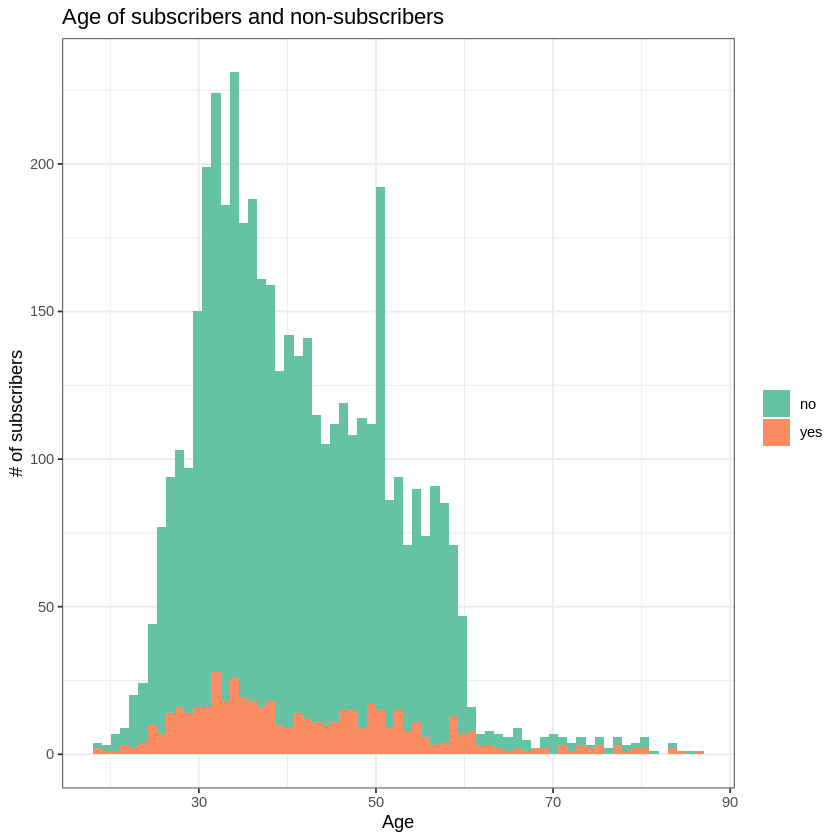

In [8]:
binnum <- length(unique(bank$age))

ggplot(bank, aes(age, fill = y)) + 
  geom_histogram(bins = binnum) + 
  ggtitle("Age of subscribers and non-subscribers") +
  xlab("Age") + 
  ylab("# of subscribers") +
  theme_bw() +
  scale_fill_brewer(palette="Set2") +
  theme(legend.title=element_blank())

In the histogram above we can see that there is one customer age that is significantly more prevalent than others.

Now I will visualize subscriber percentage by education level, marital status, occupation, and age:

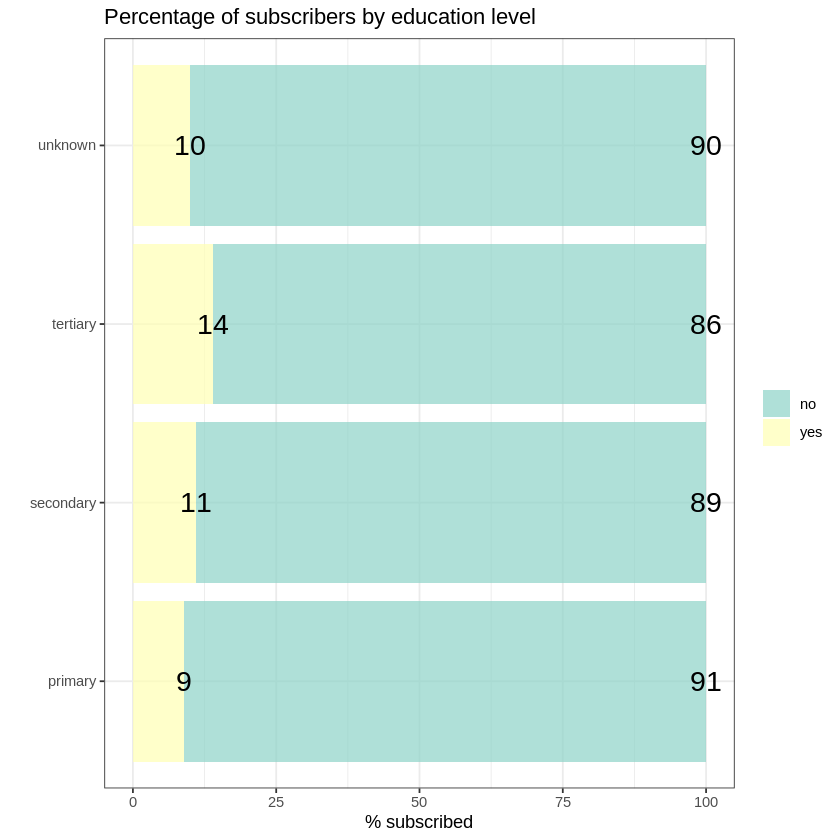

In [9]:
### subscriber % by education
yn <- bank %>% group_by(education, y) %>% summarise(n = n(), .groups = 'keep')
yed <- bank %>% group_by(education) %>% summarise(n = n())
jed <- left_join(yn, yed, by = "education")
jed <- jed %>% mutate(perc = round((n.x / n.y) * 100, digits = 0))

ggplot(jed, aes(x = education, y = perc, fill = y, label = perc)) + 
  geom_bar(stat = "identity", alpha = 0.7) + 
  geom_text(position = "stack", size = 6) + 
  ggtitle("Percentage of subscribers by education level") + 
  xlab("") +
  ylab("% subscribed") +
  scale_fill_brewer(palette="Set3") +
  theme_bw() +
  theme(legend.title=element_blank()) +
  coord_flip()

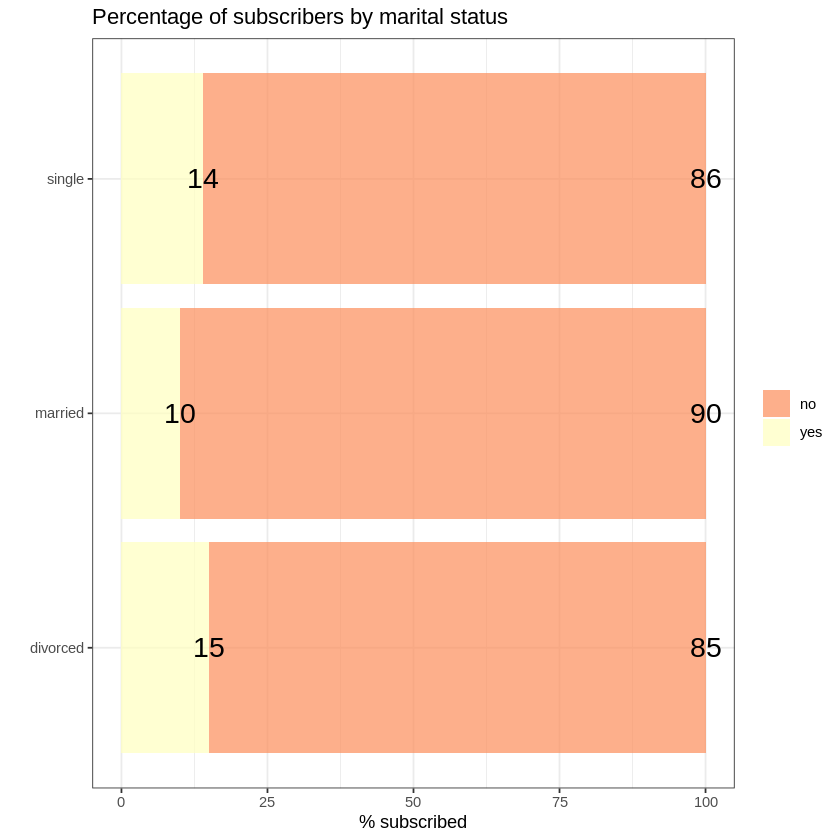

In [10]:
### subscriber % by marital status
mar <- bank %>% group_by(marital, y) %>% summarise(n = n(), .groups = 'keep')
ymar <- bank %>% group_by(marital) %>% summarise(n = n())
jmar <- left_join(mar, ymar, by = "marital")
jmar <- jmar %>% mutate(perc = round((n.x / n.y) * 100, digits = 0))

ggplot(jmar, aes(x = marital, y = perc, fill = y, label = perc)) + 
  geom_bar(stat = "identity", alpha = 0.7) + 
  geom_text(position = "stack", size = 6)  + 
  scale_fill_brewer(palette="Spectral") +
  ggtitle("Percentage of subscribers by marital status") +
  xlab("") +
  ylab("% subscribed") +
  theme_bw() +
  theme(legend.title=element_blank())+
  coord_flip()

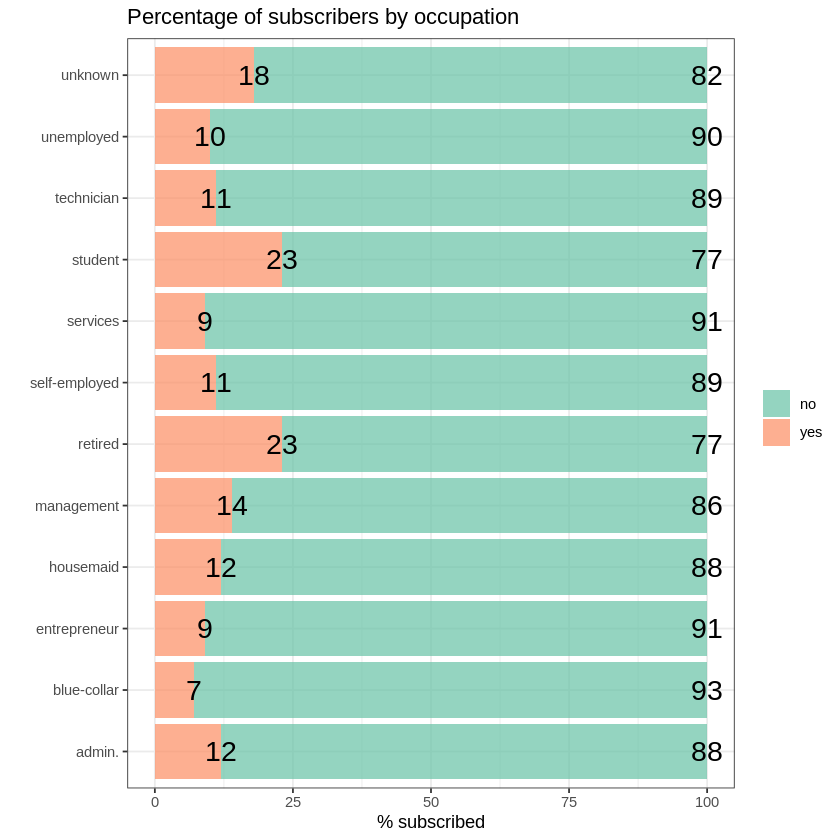

In [11]:
### subscribed by job type
ageout <- data.frame(table(bank$job, bank$y))
colnames(ageout) <- c("job", "y", "Freq")
jobs <- bank %>% group_by(job) %>% summarise(n = n())
aj <- left_join(ageout, jobs, by = "job")
aj <- aj %>% mutate(perc = round((Freq / n) * 100, digits = 0))

ggplot(aj, aes(x = job, y = perc, fill = y, label = perc)) + 
  geom_bar(stat = "identity", alpha = 0.7) + 
  geom_text(position = "stack", size = 6)  + 
  scale_fill_brewer(palette="Set2") +
  ggtitle("Percentage of subscribers by occupation") +
  xlab("") +
  ylab("% subscribed") +
  theme_bw() +
  theme(legend.title=element_blank())+
  coord_flip()

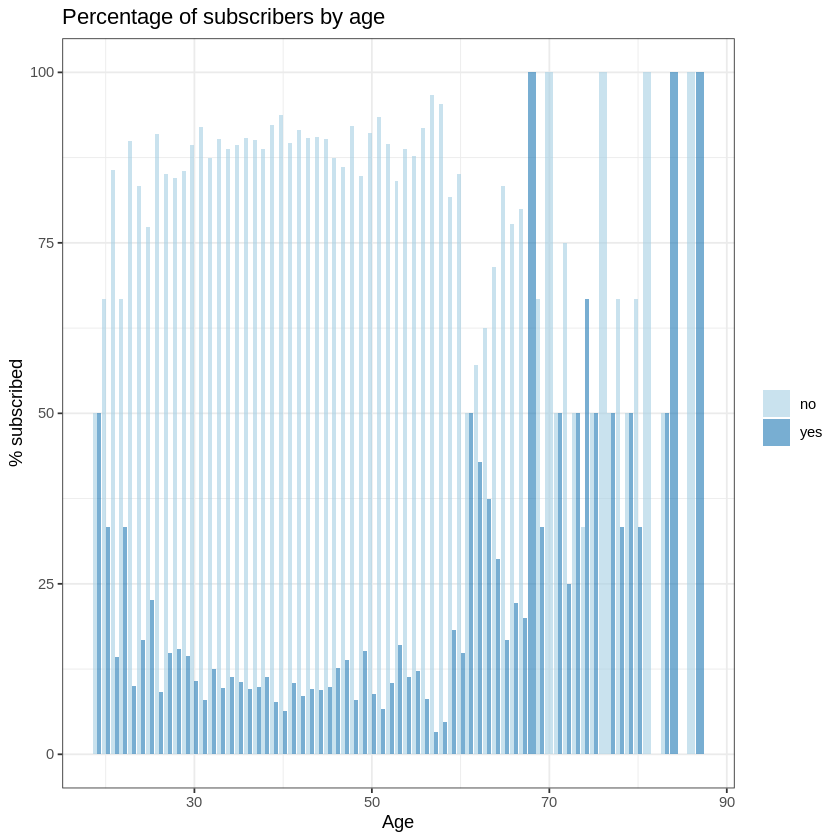

In [12]:
### subscriber by age
age <- bank %>% group_by(age, y) %>% summarise(n = n(), .groups = 'keep')
yage <- bank %>% group_by(age) %>% summarise(n = n())
jage <- left_join(age, yage, by = "age")
jage <- jage %>% mutate(perc = round((n.x / n.y) * 100, digits = 1))

ggplot(jage, aes(x = age, y = perc, fill = y, label = perc)) + 
  geom_bar(stat = "identity", position = "dodge", alpha = 0.6) + 
  scale_fill_brewer(palette="Paired") +
  ggtitle("Percentage of subscribers by age") +
  xlab("Age") +
  ylab("% subscribed") +
  theme_bw() +
  theme(legend.title=element_blank())

## Training 

Upon completing the intial exploratory data analysis, let's run it through AutoML on eight of the columns in the dataset: age, job, marital, education, default, balance, housing, loan.

In [13]:
# Create Vantage connection using tdplyr
con <- td_create_context(host = host,
                         uid = user,
                         pwd = password,
                         dType = 'native'
)

# Set connection context
td_set_context(con)

In [14]:
table_name <- in_schema(database, 'BANK_MARKETING_DATA')
table <- tbl(con, table_name)

bank <- table %>% select(c('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'y')) %>% as.data.frame()

bank$age <- as.integer(bank$age)
bank$job <- as.factor(bank$job)
bank$marital <- as.factor(bank$marital)
bank$education <- as.factor(bank$education)
bank$default <- as.factor(bank$default)
bank$balance <- as.integer(bank$balance)
bank$housing <- as.factor(bank$housing)
bank$loan <- as.factor(bank$loan)
bank$y <- as.factor(bank$y)
str(bank)

'data.frame':	4521 obs. of  9 variables:
 $ age      : int  30 33 35 30 59 35 36 39 41 43 ...
 $ job      : Factor w/ 12 levels "admin.","blue-collar",..: 11 8 5 5 2 5 7 10 3 8 ...
 $ marital  : Factor w/ 3 levels "divorced","married",..: 2 2 3 2 2 3 2 2 2 2 ...
 $ education: Factor w/ 4 levels "primary","secondary",..: 1 2 3 3 2 3 3 2 3 1 ...
 $ default  : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ balance  : int  1787 4789 1350 1476 0 747 307 147 221 -88 ...
 $ housing  : Factor w/ 2 levels "no","yes": 1 2 2 2 2 1 2 2 2 2 ...
 $ loan     : Factor w/ 2 levels "no","yes": 1 2 1 2 1 1 1 1 1 2 ...
 $ y        : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...


In [15]:
summary(bank)

      age                 job          marital         education    default   
 Min.   :19.00   management :969   divorced: 528   primary  : 678   no :4445  
 1st Qu.:33.00   blue-collar:946   married :2797   secondary:2306   yes:  76  
 Median :39.00   technician :768   single  :1196   tertiary :1350             
 Mean   :41.17   admin.     :478                   unknown  : 187             
 3rd Qu.:49.00   services   :417                                              
 Max.   :87.00   retired    :230                                              
                 (Other)    :713                                              
    balance      housing     loan        y       
 Min.   :-3313   no :1962   no :3830   no :4000  
 1st Qu.:   69   yes:2559   yes: 691   yes: 521  
 Median :  444                                   
 Mean   : 1423                                   
 3rd Qu.: 1480                                   
 Max.   :71188                                   
                  

Now we must initialize h2o and prepare the training dataset

In [21]:
h2o.init(nthreads = -1)
train_df <- as.h2o(bank)


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpMkidKw/file12264a2df80e/h2o_UnknownUser_started_from_r.out
    /tmp/RtmpMkidKw/file1226ff6bd1/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: ... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 seconds 902 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.34.0.3 
    H2O cluster version age:    13 days  
    H2O cluster name:           H2O_started_from_R_jovyan_rdv216 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   0.85 GB 
    H2O cluster total cores:    6 
    H2O cluster allowed cores:  6 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:    

We split the dataset into train and test

In [22]:
splits <- h2o.splitFrame(train_df, 0.75, seed=1234)
train <- splits[[1]]
test <- splits[[2]]

Identify predictors and response

In [23]:
y <- "y"
x <- setdiff(names(train), y)

Run AutoML for 20 base models

In [24]:
aml <- h2o.automl(x = x, y = y,
                  training_frame = train,
                  max_models = 20,
                  seed = 1)

  |======================================================================| 100%


View the AutoML Leaderboard

In [25]:
lb <- aml@leaderboard
print(lb, n = nrow(lb))  # Print all rows instead of default (6 rows)

                                                  model_id       auc   logloss
1  StackedEnsemble_BestOfFamily_4_AutoML_1_20211020_214005 0.6360513 0.3345752
2     StackedEnsemble_AllModels_4_AutoML_1_20211020_214005 0.6353481 0.3353433
3              GBM_grid_1_AutoML_1_20211020_214005_model_2 0.6353248 0.3374601
4  StackedEnsemble_BestOfFamily_8_AutoML_1_20211020_214005 0.6352213 0.3350256
5     StackedEnsemble_AllModels_7_AutoML_1_20211020_214005 0.6329329 0.3381260
6  StackedEnsemble_BestOfFamily_1_AutoML_1_20211020_214005 0.6326502 0.3351959
7  StackedEnsemble_BestOfFamily_3_AutoML_1_20211020_214005 0.6324613 0.3350789
8  StackedEnsemble_BestOfFamily_2_AutoML_1_20211020_214005 0.6303266 0.3352481
9     StackedEnsemble_AllModels_1_AutoML_1_20211020_214005 0.6301131 0.3352996
10    DeepLearning_grid_3_AutoML_1_20211020_214005_model_1 0.6299717 0.3559253
11 StackedEnsemble_BestOfFamily_5_AutoML_1_20211020_214005 0.6291382 0.3361235
12    DeepLearning_grid_1_AutoML_1_20211020_214005_m

In [26]:
model <- aml@leader
model

Model Details:

H2OBinomialModel: stackedensemble
Model ID:  StackedEnsemble_BestOfFamily_4_AutoML_1_20211020_214005 
Number of Base Models: 6

Base Models (count by algorithm type):

deeplearning          drf          gbm          glm      xgboost 
           1            2            1            1            1 

Metalearner:

Metalearner algorithm: glm
Metalearner cross-validation fold assignment:
  Fold assignment scheme: AUTO
  Number of folds: 5
  Fold column: NULL
Metalearner hyperparameters: 


H2OBinomialMetrics: stackedensemble
** Reported on training data. **

MSE:  0.08511002
RMSE:  0.2917362
LogLoss:  0.2900982
Mean Per-Class Error:  0.3381675
AUC:  0.8223422
AUCPR:  0.4172256
Gini:  0.6446844

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
         no yes    Error       Rate
no     2873 147 0.048675  =147/3020
yes     236 140 0.627660   =236/376
Totals 3109 287 0.112780  =383/3396

Maximum Metrics: Maximum metrics at their respective thre

Now we evaluate the predictions against the test dataframe.

In [27]:
pred <- h2o.predict(model, test)

  |======================================================================| 100%


In [28]:
# Eval performance:
perf <- h2o.performance(model)
perf

H2OBinomialMetrics: stackedensemble
** Reported on training data. **

MSE:  0.08511002
RMSE:  0.2917362
LogLoss:  0.2900982
Mean Per-Class Error:  0.3381675
AUC:  0.8223422
AUCPR:  0.4172256
Gini:  0.6446844

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
         no yes    Error       Rate
no     2873 147 0.048675  =147/3020
yes     236 140 0.627660   =236/376
Totals 3109 287 0.112780  =383/3396

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold       value idx
1                       max f1  0.198812    0.422323 111
2                       max f2  0.112456    0.547576 223
3                 max f0point5  0.219414    0.467687  93
4                 max accuracy  0.294981    0.898115  46
5                max precision  0.595083    1.000000   0
6                   max recall  0.038155    1.000000 361
7              max specificity  0.595083    1.000000   0
8             max absolute_mcc  0.198812    0

The h2o.predict function outputs a data frame with “no” and “yes” prediction columns with the percentage and the prediction column. With this dataframe we can get the accurracy of our model with a confusion matrix.

Confusion Matrix and Statistics

          Reference
Prediction  no yes
       no  809 171
       yes  96  49
                                          
               Accuracy : 0.7627          
                 95% CI : (0.7367, 0.7873)
    No Information Rate : 0.8044          
    P-Value [Acc > NIR] : 0.9998          
                                          
                  Kappa : 0.1339          
                                          
 Mcnemar's Test P-Value : 5.934e-06       
                                          
            Sensitivity : 0.8939          
            Specificity : 0.2227          
         Pos Pred Value : 0.8255          
         Neg Pred Value : 0.3379          
             Prevalence : 0.8044          
         Detection Rate : 0.7191          
   Detection Prevalence : 0.8711          
      Balanced Accuracy : 0.5583          
                                          
       'Positive' Class : no              
                              

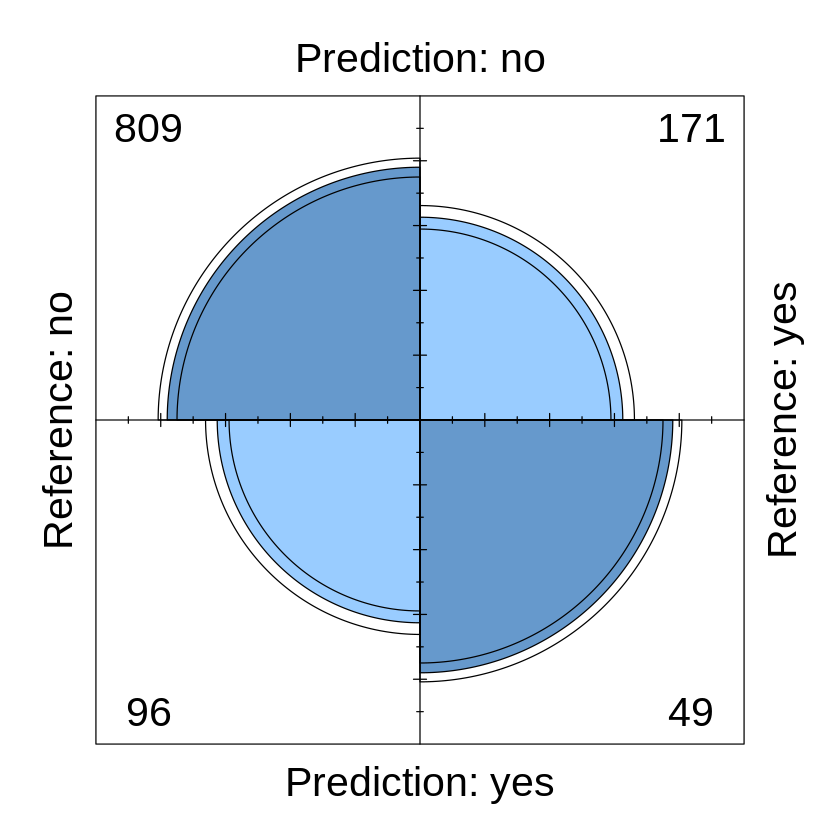

In [29]:
pred_df <- as.data.frame(pred)
test_df <- as.data.frame(test)
library(caret)
cm <- confusionMatrix(test_df$y, pred_df$predict)
cm
fourfoldplot(cm$table)
#png("artifacts/output/confusion_matrix.png", width = 860, height = 860)

And to get the model metrics

In [30]:
cm$overall

Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
  7.626667e-01   1.339292e-01   7.366929e-01   7.872589e-01   8.044444e-01 
AccuracyPValue  McnemarPValue 
  9.997580e-01   5.934026e-06